# PageRank Algorithm Implementation

This notebook is realized for the final project of the course "Information Retrieval" at the University of Trieste. \
The goal of this project is to implement and analyze the PageRank algorithm. 
The notebook structure is the following:

- [A) Dense Implementation](#1.-Dense-Implementation): A detailed description and demonstration of the dense implementation of the PageRank algorithm.
- [B) Sparse Implementation](#2.-Sparse-Implementation): An in-depth look at the sparse implementation of the PageRank algorithm.
- [C) Topic-Specific Implementation](#3.-Topic-Specific-Implementation): Exploration of the topic-specific implementation of the PageRank algorithm.

# A) a dense implementation: computation and analysis

This section briefly demonstrates the usage of the `DensePageRank` class to compute and analyze PageRank on the Seventh Graders (SG) dataset. 
The steps include loading the dataset, normalizing the adjacency matrix, computing PageRank scores iteratively and exactly, comparing the results, ranking the nodes and visualizing the sparsity pattern of the adjacency matrix for this dataset and the Wikivitals (WV) one.

Import necessary libraries and custom functions

In [1]:
import os
import time
from src.utils import * 
from src.dense_pr import DensePageRank

Restrict number of computation threads for performance consistency, to ensure that across different libraries and components that use these threads, only a single thread is utilized.

In [2]:
os.environ["MKL_NUM_THREADS"] = "1"  #  MKL library is used by numpy
os.environ["NUMEXPR_NUM_THREADS"] = "1" # NumExpr is an evaluator for numerical expressions
os.environ["OMP_NUM_THREADS"] = "1" # OpenMP multi-platform shared memory multiprocessing API

Load the SG dataset and examine its features

In [3]:
dataset_sg_path = './data/input/seventh_graders'
pagerank_dense_sg = DensePageRank()
pagerank_dense_sg.load_network(dataset_sg_path, is_undirected=False)
pagerank_dense_sg.load_node_names(dataset_sg_path)

In [4]:
# display the number of nodes and edges
print(f"The number of nodes: {pagerank_dense_sg.num_nodes}")
print(f"The number of edges: {pagerank_dense_sg.num_edges}")

# display the top 5 node labels
print(pagerank_dense_sg.node_labels.head(5))

The number of nodes: 29
The number of edges: 376
   node_id            label
0         0       male_noah
1         1       male_liam
2         2    male_william
3         3   male_benjamin
4         4      male_jacob


Plot the SG network to get a sense of the dataset's structure.

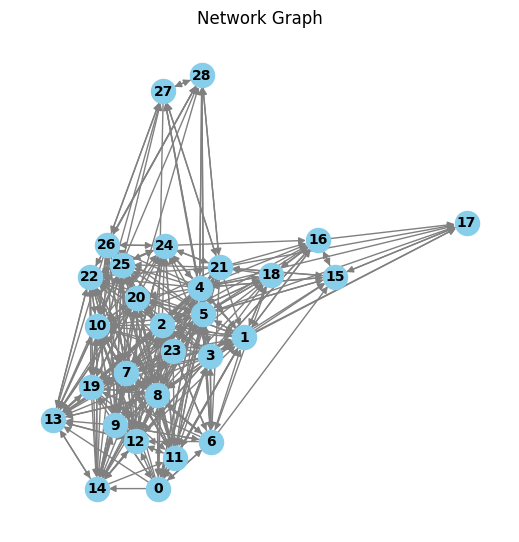

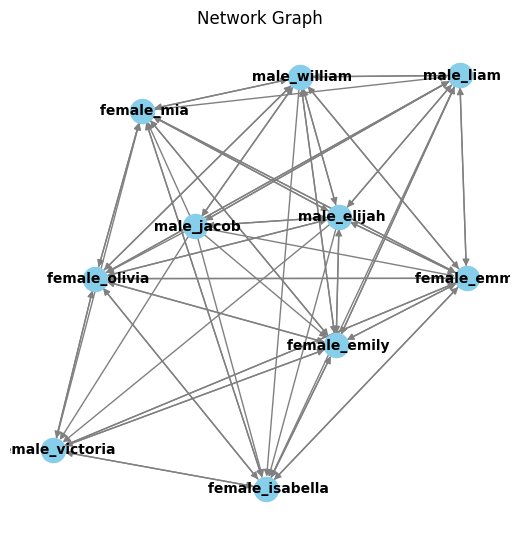

In [5]:
# Plot all nodes of SG network
plot_network(pagerank_dense_sg.adjacency_matrix)

# Plot just the top 10 nodes by out degree of the SG network
plot_network(pagerank_dense_sg.adjacency_matrix, max_nodes_to_show=10, node_labels=pagerank_dense_sg.node_labels)

Normalize the adjacency matrix and iteratively calculate PageRank scores 

In [6]:
pagerank_dense_sg.row_normalize_adj()
dense_sg_pagerank_scores, dense_sg_residuals = pagerank_dense_sg.power_iterate(teleport_prob=0.15, epsilon=1e-9, max_iterations=100, dangling_handling=False)

# verify the sum of the PageRank scores
check_pagerank_sum(dense_sg_pagerank_scores)

The sum of the PageRank score vector is: 1.00


In [7]:
# check the sum of each row in the row-normalized adjacency matrix
row_sums = pagerank_dense_sg.normalized_adjacency.sum(axis=1)
for i, (out_degree, row_sum) in enumerate(zip(pagerank_dense_sg.out_degrees, row_sums)):
    print(f"node: {i}, out-degree: {int(out_degree)}, matrix row sum: {row_sum:.2f}")

node: 0, out-degree: 14, matrix row sum: 1.00
node: 1, out-degree: 15, matrix row sum: 1.00
node: 2, out-degree: 17, matrix row sum: 1.00
node: 3, out-degree: 23, matrix row sum: 1.00
node: 4, out-degree: 27, matrix row sum: 1.00
node: 5, out-degree: 27, matrix row sum: 1.00
node: 6, out-degree: 12, matrix row sum: 1.00
node: 7, out-degree: 14, matrix row sum: 1.00
node: 8, out-degree: 16, matrix row sum: 1.00
node: 9, out-degree: 12, matrix row sum: 1.00
node: 10, out-degree: 14, matrix row sum: 1.00
node: 11, out-degree: 10, matrix row sum: 1.00
node: 12, out-degree: 13, matrix row sum: 1.00
node: 13, out-degree: 8, matrix row sum: 1.00
node: 14, out-degree: 9, matrix row sum: 1.00
node: 15, out-degree: 5, matrix row sum: 1.00
node: 16, out-degree: 6, matrix row sum: 1.00
node: 17, out-degree: 1, matrix row sum: 1.00
node: 18, out-degree: 6, matrix row sum: 1.00
node: 19, out-degree: 13, matrix row sum: 1.00
node: 20, out-degree: 15, matrix row sum: 1.00
node: 21, out-degree: 19, mat

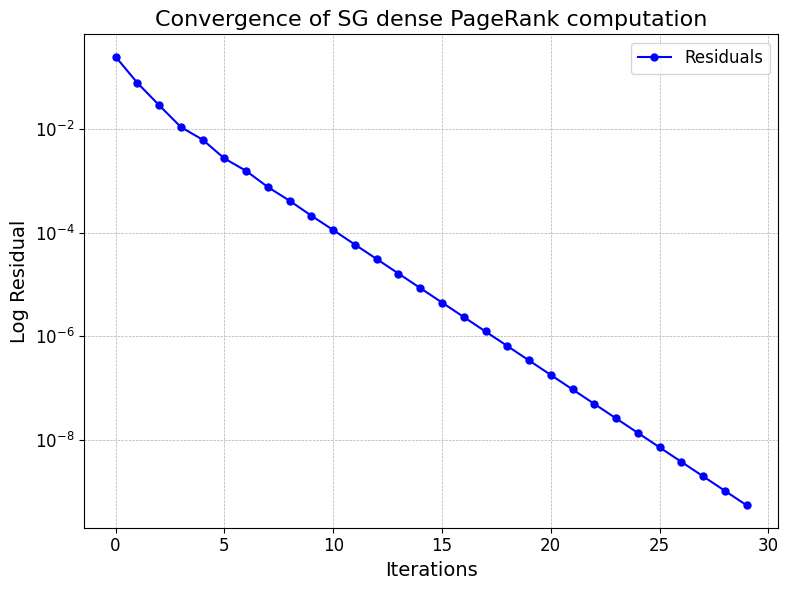

In [8]:
# plot residuals from PageRank iterations
plot_residuals(dense_sg_residuals, 'Convergence of SG dense PageRank computation','./data/output/sg_residuals.jpeg')

Compute exact PageRank scores and compare them to the iterative scores

In [9]:
dense_sg_exact_pagerank_scores = pagerank_dense_sg.closed_form(teleport_prob=0.15)
error = compute_pagerank_error(dense_sg_exact_pagerank_scores, dense_sg_pagerank_scores, 1)
print(f"The error between exact and iterative formulation of PageRank scores is: {error:.2e}")

The error between exact and iterative formulation of PageRank scores is: 5.96e-10


Rank SG nodes and display top 10

In [10]:
top_ranked_nodes = pagerank_dense_sg.sort_nodes_by_score(dense_sg_pagerank_scores, top_elements=10)
print(top_ranked_nodes)

   rank  node_id              label     score
0     1         7       female_emma  0.052159
1     2         8     female_olivia  0.051792
2     3        10   female_isabella  0.050826
3     4        20      female_emily  0.047817
4     5        12        female_mia  0.046645
5     6        13     female_amelia  0.045363
6     7        22     female_harper  0.044910
7     8         5       male_elijah  0.044560
8     9        19    female_abigail  0.043734
9    10        11     female_sophia  0.043454


Plot the SG network taking into account PageRank scores as node dimension

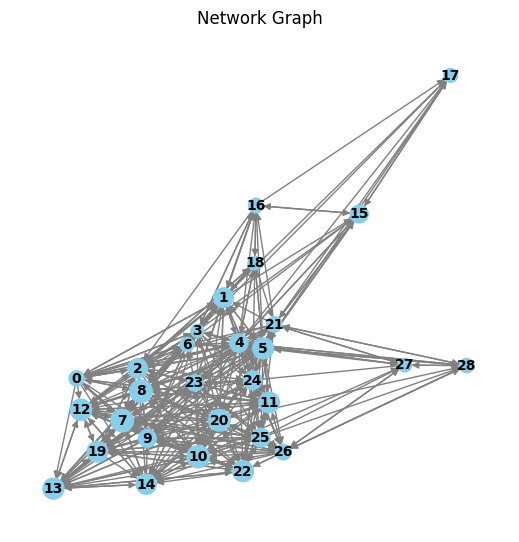

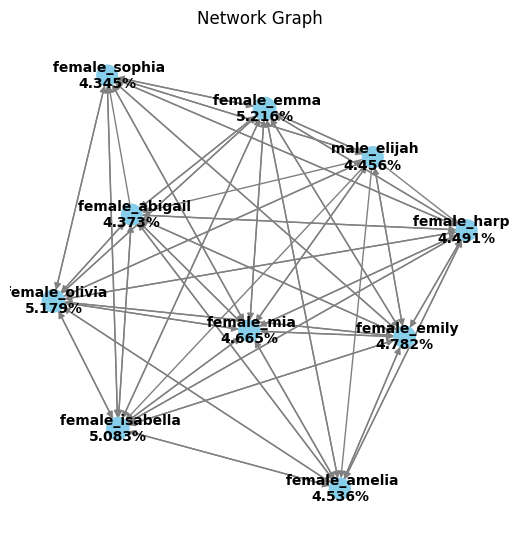

In [11]:
# Plot all nodes of SG network sized by their own PageRank scores
plot_network(pagerank_dense_sg.adjacency_matrix, page_ranks=dense_sg_pagerank_scores)

# Plot just the top 10 nodes of the SG network sized by PageRank score
plot_network(pagerank_dense_sg.adjacency_matrix, page_ranks=dense_sg_pagerank_scores, max_nodes_to_show=10, node_labels=pagerank_dense_sg.node_labels)

Try to apply the very same passages on the VW dataset

In [12]:
dataset_wv_path = './data/input/wiki'
pagerank_dense_wv = DensePageRank()
pagerank_dense_wv.load_network(dataset_wv_path, is_undirected=False)
pagerank_dense_wv.load_node_names(dataset_wv_path)

In [13]:
# display the number of nodes and edges
print(f"The number of nodes: {pagerank_dense_wv.num_nodes}")
print(f"The number of edges: {pagerank_dense_wv.num_edges}")

# display the top 5 node labels
print(pagerank_dense_wv.node_labels.head(5))

The number of nodes: 10011
The number of edges: 824999
   node_id                     label
0         0                        0
1         1                        1
2         2               100 metres
3         3          14th Dalai Lama
4         4  1556 Shaanxi earthquake


Observe the extended time needed for normalizing the adjacency matrix

In [14]:
start_dense_wv_time = time.perf_counter()
pagerank_dense_wv.row_normalize_adj()
dense_wv_pagerank_scores, dense_wv_residuals = pagerank_dense_wv.power_iterate(teleport_prob=0.15, epsilon=1e-9, max_iterations=100, dangling_handling=True)
stop_dense_wv_time = time.perf_counter()

# verify the sum of the PageRank scores
check_pagerank_sum(dense_wv_pagerank_scores)

The sum of the PageRank score vector is: 1.00


### Can we improve to handle even larger datasets?

Let's begin with a closer observation of the SG vs. VW datasets to understand their characteristics

In [15]:
# compute a sparsity ratio of SG network
sparsity = pagerank_dense_sg.compute_sparsity()
print(f"The sparsity of SG network is : {sparsity:.4f}")

# compute a sparsity ratio of WV network
sparsity = pagerank_dense_wv.compute_sparsity()
print(f"The sparsity of WV network is : {sparsity:.4f}")

The sparsity of SG network is : 0.5529
The sparsity of WV network is : 0.9918


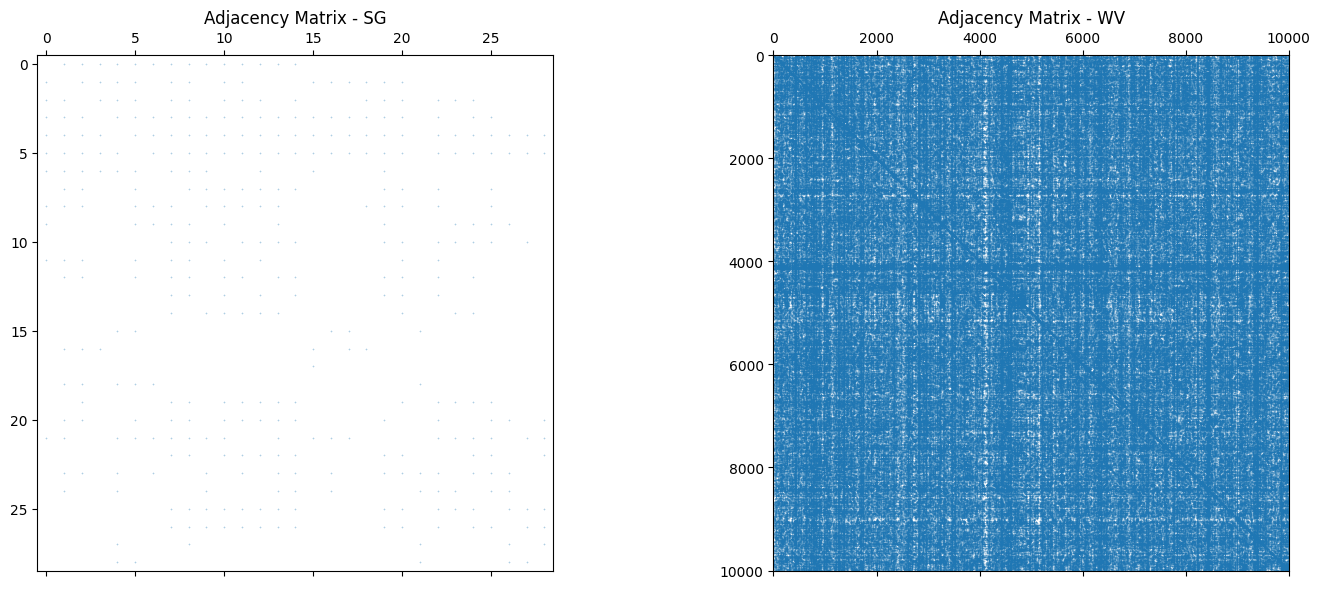

In [16]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot the SG adjacency matrix
axs[0].spy(pagerank_dense_sg.adjacency_matrix, markersize=0.1)
axs[0].set_title('Adjacency Matrix - SG')

# Plot the WV adjacency matrix
axs[1].spy(pagerank_dense_wv.adjacency_matrix, markersize=0.1)
axs[1].set_title('Adjacency Matrix - WV')

plt.tight_layout()
plt.show()

# B) a sparse implementation: computation and analysis

Now we will proceed showing the improvement in performance coming from the `SparsePageRank` class implementation, to compute and analyze PageRank on the larger WV dataset. \
As before, our steps include loading again the dataset, normalizing adjacency matrix, computing PageRank iteratively and exactly, comparing results and ranking nodes. \
We will finally verify that results are in line with our `DensePageRank` and also with the results of public `scikit-network` library which we will use as benchmark.

In [17]:
from src.sparse_pr import SparsePageRank

Load the WV dataset

In [18]:
dataset_wv_path = './data/input/wiki'
pagerank_sparse_wv = SparsePageRank()
pagerank_sparse_wv.load_network(dataset_wv_path, is_undirected=False)
pagerank_sparse_wv.load_node_names(dataset_wv_path)

Normalize the adjacency matrix and iteratively calculate PageRank scores

In [19]:
start_sparse_wv_time = time.perf_counter()
pagerank_sparse_wv.row_normalize_adj()
sparse_wv_pagerank_scores, sparse_wv_residuals = pagerank_sparse_wv.power_iterate(teleport_prob=0.15, epsilon=1e-9, max_iterations=100, dangling_handling=True)
stop_sparse_wv_time = time.perf_counter()

# verify the sum of the PageRank scores
check_pagerank_sum(sparse_wv_pagerank_scores)

The sum of the PageRank score vector is: 1.00


In [20]:
# check the sum of each row in the row-normalized adjacency matrix
import numpy as np
row_sums = np.asarray(pagerank_sparse_wv.normalized_adjacency.sum(axis=1)).flatten()
for i, (out_degree, row_sum) in enumerate(zip(pagerank_sparse_wv.out_degrees, row_sums)):
    print(f"node: {i}, out-degree: {int(out_degree)}, matrix row sum: {row_sum:.2f}")

node: 0, out-degree: 85, matrix row sum: 1.00
node: 1, out-degree: 76, matrix row sum: 1.00
node: 2, out-degree: 75, matrix row sum: 1.00
node: 3, out-degree: 132, matrix row sum: 1.00
node: 4, out-degree: 21, matrix row sum: 1.00
node: 5, out-degree: 43, matrix row sum: 1.00
node: 6, out-degree: 31, matrix row sum: 1.00
node: 7, out-degree: 108, matrix row sum: 1.00
node: 8, out-degree: 31, matrix row sum: 1.00
node: 9, out-degree: 25, matrix row sum: 1.00
node: 10, out-degree: 104, matrix row sum: 1.00
node: 11, out-degree: 105, matrix row sum: 1.00
node: 12, out-degree: 61, matrix row sum: 1.00
node: 13, out-degree: 69, matrix row sum: 1.00
node: 14, out-degree: 184, matrix row sum: 1.00
node: 15, out-degree: 27, matrix row sum: 1.00
node: 16, out-degree: 48, matrix row sum: 1.00
node: 17, out-degree: 28, matrix row sum: 1.00
node: 18, out-degree: 20, matrix row sum: 1.00
node: 19, out-degree: 26, matrix row sum: 1.00
node: 20, out-degree: 98, matrix row sum: 1.00
node: 21, out-degr

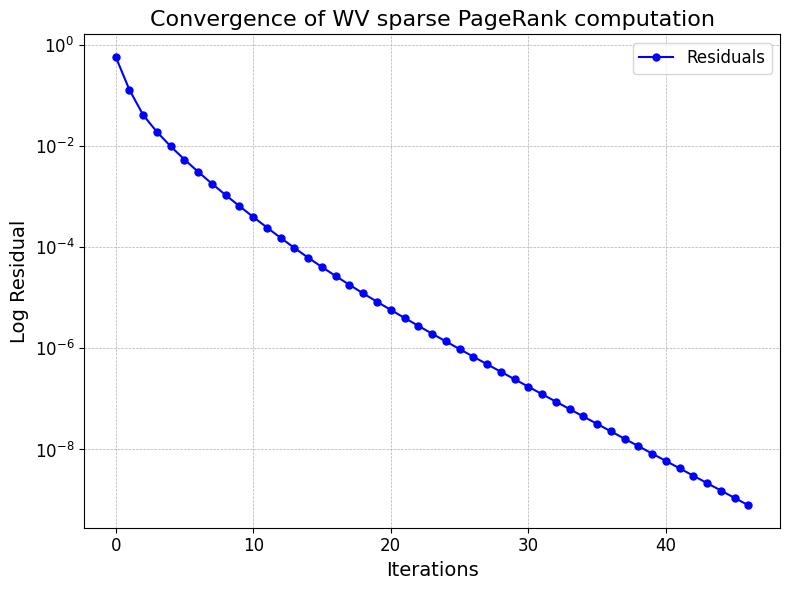

In [21]:
# plot residuals from PageRank iterations
plot_residuals(sparse_wv_residuals, 'Convergence of WV sparse PageRank computation', './data/output/sparse_wv_residuals.jpeg')

Compute exact PageRank scores and compare them to the iterative scores

In [22]:
sparse_wv_exact_pagerank_scores = pagerank_sparse_wv.closed_form(teleport_prob=0.15)
error = compute_pagerank_error(sparse_wv_exact_pagerank_scores, sparse_wv_pagerank_scores, 1)
print(f"The error between exact and iterative formulation of PageRank scores is: {error:.2e}")

The error between exact and iterative formulation of PageRank scores is: 4.90e-07


Rank WV nodes and display top 10

In [23]:
top_ranked_nodes = pagerank_sparse_wv.sort_nodes_by_score(sparse_wv_pagerank_scores, top_elements=10)
print(top_ranked_nodes)

   rank  node_id                          label     score
0     1      9380                 United States  0.002066
1     2      9856                  World War II  0.001832
2     3      9000            The New York Times  0.001790
3     4      3460  Geographic coordinate system  0.001558
4     5      5206                         Latin  0.001531
5     6      4420                         India  0.001473
6     7      1692                         China  0.001455
7     8      3233                        France  0.001392
8     9      9378                United Kingdom  0.001384
9    10      9855                   World War I  0.001151


### Comparison between the Dense and Sparse implementations on WV dataset: time and precision dimensions

In [24]:
# difference among the WV PageRank scores computed by dense and sparse formulations
delta_wv_scores = compute_pagerank_error(dense_wv_pagerank_scores, sparse_wv_pagerank_scores, 1)
print(f"The difference between the PageRank scores calculated with the dense and with the sparse implementation is: {delta_wv_scores:.2e}")

The difference between the PageRank scores calculated with the dense and with the sparse implementation is: 0.00e+00


In [25]:
# difference among time required to compute PageRank scores by dense and sparse formulations
time_dense_wv = stop_dense_wv_time - start_dense_wv_time
time_sparse_vw = stop_sparse_wv_time - start_sparse_wv_time

print(f"Time elapsed for processing PR on WV dataset with the dense implementation is: {time_dense_wv:0.4f} seconds")
print(f"Time elapsed for processing PR on WV dataset with the sparse implementation is: {time_sparse_vw:0.4f} seconds")
print(f"The difference in time between the PageRank calculation with the dense and with the sparse implementation is: {time_dense_wv - time_sparse_vw:0.4f} seconds")

Time elapsed for processing PR on WV dataset with the dense implementation is: 10.8703 seconds
Time elapsed for processing PR on WV dataset with the sparse implementation is: 0.0391 seconds
The difference in time between the PageRank calculation with the dense and with the sparse implementation is: 10.8312 seconds


### Comparison between the Sparse implementation and scikit-network benchmark on WV datset: time and precision dimensions

In [26]:
from sknetwork.data import load_netset
from sknetwork.ranking import PageRank, top_k

# load dataset
wikivitals = load_netset('wikivitals')

# separate dataset into adjacency matrix, node names and node subjects
adjacency = wikivitals.adjacency
names = wikivitals.names
topics = wikivitals.labels
topic_names = wikivitals.names_labels

# initialize PageRank object
pagerank_sknetwork_wv = PageRank(damping_factor=0.85, solver="piteration", n_iter=100, tol=10**-6)

# compute Page-Rank on the entire graph
start_sknetwork_wv_time = time.perf_counter()
sknetwork_wv_pagerank_scores = pagerank_sknetwork_wv.fit_predict(adjacency, weights=None)
stop_sknetwork_wv_time = time.perf_counter()

# verify the sum of the PageRank scores
check_pagerank_sum(sknetwork_wv_pagerank_scores)

# print top-10 pages' name and PageRank score
top_indices = sorted(range(len(sknetwork_wv_pagerank_scores)), key=lambda x: sknetwork_wv_pagerank_scores[x], reverse=True)[:10]
for index in top_indices:
    print(names[index], round(sknetwork_wv_pagerank_scores[index], 6))

Parsing files...
Done.
The sum of the PageRank score vector is: 1.00
United States 0.002065
World War II 0.001832
The New York Times 0.00179
Geographic coordinate system 0.001558
Latin 0.001531
India 0.001473
China 0.001455
France 0.001392
United Kingdom 0.001383
World War I 0.001151


In [27]:
# difference among the WV PageRank scores computed by sparse and sknetwork formulations
delta_wv_scores = compute_pagerank_error(sknetwork_wv_pagerank_scores, sparse_wv_pagerank_scores, 1)
print(f"The difference between the PageRank scores calculated with the sparse and with the sknetwork implementation is: {delta_wv_scores:.2e}")

The difference between the PageRank scores calculated with the sparse and with the sknetwork implementation is: 3.40e-04


In [28]:
# difference among time required to compute PageRank scores by sparse and sknetwork formulations
time_sparse_vw = stop_sparse_wv_time - start_sparse_wv_time
time_sknetwork_wv = stop_sknetwork_wv_time - start_sknetwork_wv_time

print(f"Time elapsed for processing PR on WV dataset with the sparse implementation is: {time_sparse_vw:0.4f} seconds")
print(f"Time elapsed for processing PR on WV dataset with the sknetwork implementation is: {time_sknetwork_wv:0.4f} seconds")
print(f"The difference in time between the PageRank calculation with the sparse and with the sknetwork implementation is: {time_sknetwork_wv - time_sparse_vw:0.4f} seconds")

Time elapsed for processing PR on WV dataset with the sparse implementation is: 0.0391 seconds
Time elapsed for processing PR on WV dataset with the sknetwork implementation is: 0.0573 seconds
The difference in time between the PageRank calculation with the sparse and with the sknetwork implementation is: 0.0181 seconds


# C) a topic-specific implementation: computation and analysis

Finally, we adapt the previous `SparsePageRank` class to perform topic-specific PageRank from a specific list of pages (possibly related to a specific topic). \
Again we test it on the WV datset and then we compare the result against our `scikit-network` benchmark for topic-specific Pagerank.

In [29]:
from src.ts_pr import TopicSpecificPageRank

Load the WV dataset (with extended data on pages' topics)

In [30]:
dataset_wv_path = './data/input/wiki'
pagerank_ts_wv = TopicSpecificPageRank()
pagerank_ts_wv.load_network(dataset_wv_path, is_undirected=False)
pagerank_ts_wv.load_node_names(dataset_wv_path)
pagerank_ts_wv.load_node_topics(dataset_wv_path)
pagerank_ts_wv.load_topics(dataset_wv_path)

Select nodes on a single topic

In [31]:
topic_list = pagerank_ts_wv.topic_selection(topic=0)
print(f"The pages/nodes concerning the selected topic are the following: {topic_list}")

The topic selected is: 0 Arts
The pages/nodes concerning the selected topic are the following: [12, 14, 16, 17, 18, 19, 20, 21, 59, 60, 70, 72, 79, 95, 96, 97, 130, 135, 144, 155, 157, 216, 297, 301, 322, 362, 404, 406, 423, 424, 428, 429, 430, 435, 471, 488, 489, 495, 564, 585, 586, 597, 609, 611, 612, 613, 614, 627, 644, 649, 650, 651, 670, 671, 699, 753, 794, 822, 840, 859, 860, 864, 904, 905, 906, 930, 931, 936, 947, 956, 994, 997, 1018, 1039, 1049, 1069, 1099, 1126, 1151, 1155, 1165, 1179, 1185, 1213, 1216, 1219, 1232, 1247, 1252, 1296, 1298, 1314, 1355, 1371, 1380, 1388, 1456, 1482, 1519, 1542, 1569, 1604, 1638, 1685, 1686, 1696, 1697, 1704, 1721, 1728, 1730, 1738, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1777, 1781, 1786, 1806, 1815, 1816, 1817, 1852, 1885, 1901, 1913, 1915, 1917, 1959, 1972, 1973, 1974, 2024, 2025, 2081, 2091, 2093, 2126, 2137, 2163, 2207, 2231, 2249, 2265, 2278, 2293, 2295, 2311, 2349, 2357, 2361, 2388, 2407, 2433, 2434, 2449, 2451, 2457, 2487, 24

Normalize the adjacency matrix and iteratively calculate PageRank scores

In [32]:
start_ts_wv_time = time.perf_counter()
pagerank_ts_wv.row_normalize_adj()
ts_wv_pagerank_scores, ts_wv_residuals = pagerank_ts_wv.power_iterate(weights=topic_list, teleport_prob=0.15, epsilon=1e-9, max_iterations=100, dangling_handling=True)
stop_ts_wv_time = time.perf_counter()

# verify the sum of the PageRank scores
check_pagerank_sum(ts_wv_pagerank_scores)

The sum of the PageRank score vector is: 1.00


In [33]:
# Check the sum of each row in the row-normalized matrix
row_sums = np.asarray(pagerank_ts_wv.normalized_adjacency.sum(axis=1)).flatten()
for i, (out_degree, row_sum) in enumerate(zip(pagerank_ts_wv.out_degrees, row_sums)):
    print(f"Node: {i}, Out-degree: {int(out_degree)}, Row sum: {row_sum:.2f}")

Node: 0, Out-degree: 85, Row sum: 1.00
Node: 1, Out-degree: 76, Row sum: 1.00
Node: 2, Out-degree: 75, Row sum: 1.00
Node: 3, Out-degree: 132, Row sum: 1.00
Node: 4, Out-degree: 21, Row sum: 1.00
Node: 5, Out-degree: 43, Row sum: 1.00
Node: 6, Out-degree: 31, Row sum: 1.00
Node: 7, Out-degree: 108, Row sum: 1.00
Node: 8, Out-degree: 31, Row sum: 1.00
Node: 9, Out-degree: 25, Row sum: 1.00
Node: 10, Out-degree: 104, Row sum: 1.00
Node: 11, Out-degree: 105, Row sum: 1.00
Node: 12, Out-degree: 61, Row sum: 1.00
Node: 13, Out-degree: 69, Row sum: 1.00
Node: 14, Out-degree: 184, Row sum: 1.00
Node: 15, Out-degree: 27, Row sum: 1.00
Node: 16, Out-degree: 48, Row sum: 1.00
Node: 17, Out-degree: 28, Row sum: 1.00
Node: 18, Out-degree: 20, Row sum: 1.00
Node: 19, Out-degree: 26, Row sum: 1.00
Node: 20, Out-degree: 98, Row sum: 1.00
Node: 21, Out-degree: 154, Row sum: 1.00
Node: 22, Out-degree: 87, Row sum: 1.00
Node: 23, Out-degree: 99, Row sum: 1.00
Node: 24, Out-degree: 8, Row sum: 1.00
Node:

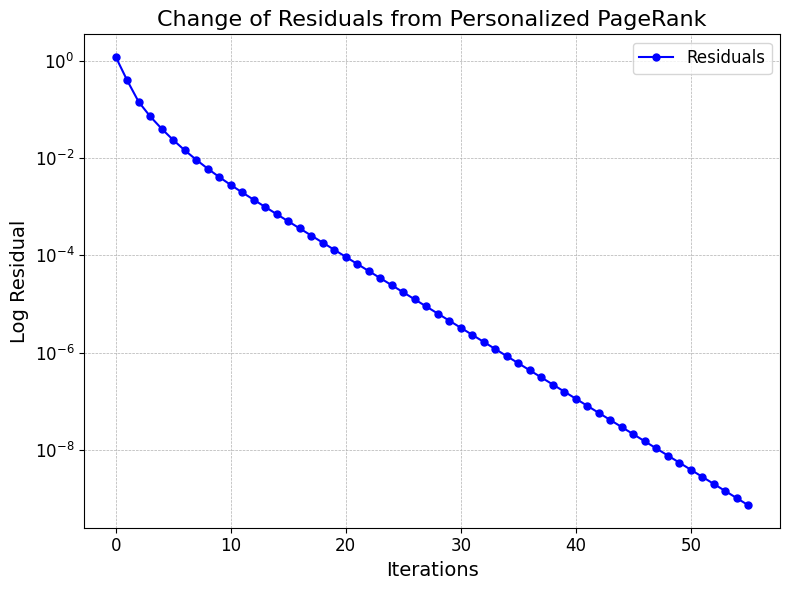

In [34]:
# Plot residuals
plot_residuals(ts_wv_residuals, 'Change of Residuals from Personalized PageRank', './data/output/ts_wv_residuals.jpeg')

Compute exact PageRank scores and compare them to the iterative scores

In [35]:
# Compute and compare exact PageRank score
ts_wv_exact_pagerank_scores = pagerank_ts_wv.closed_form(weights=topic_list)
error = np.linalg.norm(ts_wv_exact_pagerank_scores - ts_wv_pagerank_scores, 1)
print(f"The error between exact and iterative formulation of PageRank scores is: {error:.2e}")

The error between exact and iterative formulation of PageRank scores is: 1.11e-07


Rank WV nodes, select only those concerning the selected topic and display top 10

In [36]:
ts_array = np.isin(np.arange(len(ts_wv_pagerank_scores)), topic_list).astype(int)
ts_wv_pagerank_scores_subset = ts_wv_pagerank_scores * ts_array
top_ranked_nodes = pagerank_ts_wv.sort_nodes_by_score(ts_wv_pagerank_scores_subset, top_elements=10)
print(top_ranked_nodes)

   rank  node_id                        label     score
0     1      2809     Encyclopædia Britannica  0.001285
1     2      7767                 Romanticism  0.001159
2     3      4707                        Jazz  0.001085
3     4      6018                   Modernism  0.001010
4     5       904                     Baroque  0.000895
5     6      1815             Classical music  0.000830
6     7      6611                       Opera  0.000797
7     8      6189          Musical instrument  0.000786
8     9      6640                   Orchestra  0.000771
9    10      5876  Metropolitan Museum of Art  0.000770


### Comparison between the Topic-Specific sparse implementation and scikit-network topic-specific benchmark on WV datset

In [37]:
# Compute Topic-Specific PageRank for WV on all 11 topics one by one with our implementation
selection_list = []

# Iterate over each topic and compute PageRank
for topic in range(len(pagerank_ts_wv.topics)):
    topic_list = pagerank_ts_wv.topic_selection(topic=topic, verbose=False)
    pagerank_ts_wv.row_normalize_adj()
    ts_wv_pagerank_scores, _ = pagerank_ts_wv.power_iterate(weights=topic_list, teleport_prob=0.15, epsilon=1e-9, max_iterations=100, dangling_handling=True)
    ts_array = np.isin(np.arange(len(ts_wv_pagerank_scores)), topic_list).astype(int) # array where elements are 1 if the node belongs to the current topic, else 0
    ts_wv_pagerank_scores_subset = ts_wv_pagerank_scores * ts_array # zero out scores of nodes not belonging to the current topic
    top_ranked_nodes = pagerank_ts_wv.sort_nodes_by_score(ts_wv_pagerank_scores_subset, top_elements=5)
    selection_list.append(top_ranked_nodes)

# Display the 5 top-ranked nodes for each of 11 topics
for index, topic in pagerank_ts_wv.topics.iterrows():
    print(f"The top 5 pages for topic {index} - '{topic[1]}' are:")
    print(selection_list[index], "\n")

The top 5 pages for topic 0 - 'Arts' are:
   rank  node_id                     label     score
0     1      2809  Encyclopædia Britannica  0.001285
1     2      7767              Romanticism  0.001159
2     3      4707                     Jazz  0.001085
3     4      6018                Modernism  0.001010
4     5       904                  Baroque  0.000895 

The top 5 pages for topic 1 - 'Biological and health sciences' are:
   rank  node_id                label     score
0     1      8881  Taxonomy (biology)  0.003579
1     2       482              Animal  0.002913
2     3      1729            Chordate  0.001804
3     4      7087               Plant  0.001764
4     5      8465             Species  0.001718 

The top 5 pages for topic 2 - 'Everyday life' are:
   rank  node_id                  label     score
0     1      6588         Olympic Games  0.001474
1     2       693  Association football  0.001381
2     3       924            Basketball  0.001169
3     4       917            

In [38]:
# Compute Topic-Specific PageRank for WV on all 11 topics one by one via the scikit-network library
selection_list = []

# Iterate over each topic and compute PageRank
for topic in np.arange(len(topic_names)):
    ts_pagerank = pagerank_sknetwork_wv.fit_predict(input_matrix=adjacency, weights=(topics==topic))
    ts_pagerank_subset = ts_pagerank * (topics==topic) # zero out scores of nodes not belonging to current topic
    selection_list.append(top_k(ts_pagerank_subset, 5))

# Display the 5 top-ranked nodes for each of 11 topics
selection = np.array(selection_list)
for index, topic in enumerate(topic_names):
    print(f"The top 5 pages for topic {index}-'{topic}' are: {names[selection[index, :5]]}")

The top 5 pages for topic 0-'Arts' are: ['Encyclopædia Britannica' 'Romanticism' 'Jazz' 'Modernism' 'Baroque']
The top 5 pages for topic 1-'Biological and health sciences' are: ['Taxonomy (biology)' 'Animal' 'Chordate' 'Plant' 'Species']
The top 5 pages for topic 2-'Everyday life' are: ['Olympic Games' 'Association football' 'Basketball' 'Baseball' 'Softball']
The top 5 pages for topic 3-'Geography' are: ['Geographic coordinate system' 'United States' 'China' 'France' 'India']
The top 5 pages for topic 4-'History' are: ['World War II' 'World War I' 'Roman Empire' 'Ottoman Empire'
 'Middle Ages']
The top 5 pages for topic 5-'Mathematics' are: ['Real number' 'Function (mathematics)' 'Complex number'
 'Set (mathematics)' 'Integer']
The top 5 pages for topic 6-'People' are: ['Aristotle' 'Plato' 'Augustine of Hippo' 'Winston Churchill'
 'Thomas Aquinas']
The top 5 pages for topic 7-'Philosophy and religion' are: ['Christianity' 'Islam' 'Buddhism' 'Hinduism' 'Catholic Church']
The top 5 page

In conclusion, we observe that the results from our implementation are consistent with those from the scikit-network library.